# How convolution neural networks see the world
Visualize convolution filters  
https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [1]:
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

/home/saucecat/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- dimensions of the generated pictures for each filter.

In [2]:
img_width = 128
img_height = 128

- the name of the layer we want to visualize

In [3]:
layer_name = 'block5_conv1'

- get the list of layers in VGG16

In [4]:
model = vgg16.VGG16(weights='imagenet', include_top=False)
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [5]:
layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7f6b03c7f190>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7f6b03c7f1d0>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7f6b03c7f390>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7f6b03c23f90>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7f6b03c3ac10>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7f6b03c4fc10>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7f6b039d3bd0>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7f6b039e6a90>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7f6b039f9890>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7f6b0398ea10>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7f6b03948b50>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7f6b03948d90>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7f6b03970ad0>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7f6b03903dd

- util function to convert a tensor into a valid image

In [6]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

- get model information

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

- this is the placeholder for the input images

In [8]:
input_img = model.input

- utility function to normalize a tensor by its L2 norm

In [9]:
def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [10]:
K.image_data_format()

'channels_last'

In [19]:
def update_input_img(layer_name, n_base, n_choose):
    kept_filters = []
    for filter_index in range(n_base):
        
        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # step size for gradient ascent
        step = 1.

        # we start from a gray image with some random noise
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random((1, 3, img_width, img_height))
        else:
            input_img_data = np.random.random((1, img_width, img_height, 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # we run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step
            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break

        # decode the resulting input image
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))

    # we will stich the best filters on a grid.
    n = int(np.ceil(np.sqrt(n_choose)))

    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:n * n]

    # build a black picture with enough space for
    margin = 5
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, loss = kept_filters[i * n + j]
            stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                             (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img
    
    return stitched_filters

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
%time stitched_filters = update_input_img(layer_name='block5_conv1', n_base=200, n_choose=64)

CPU times: user 2min 26s, sys: 2.95 s, total: 2min 29s
Wall time: 2min 31s


Text(0.5,1,u'block5_conv1')

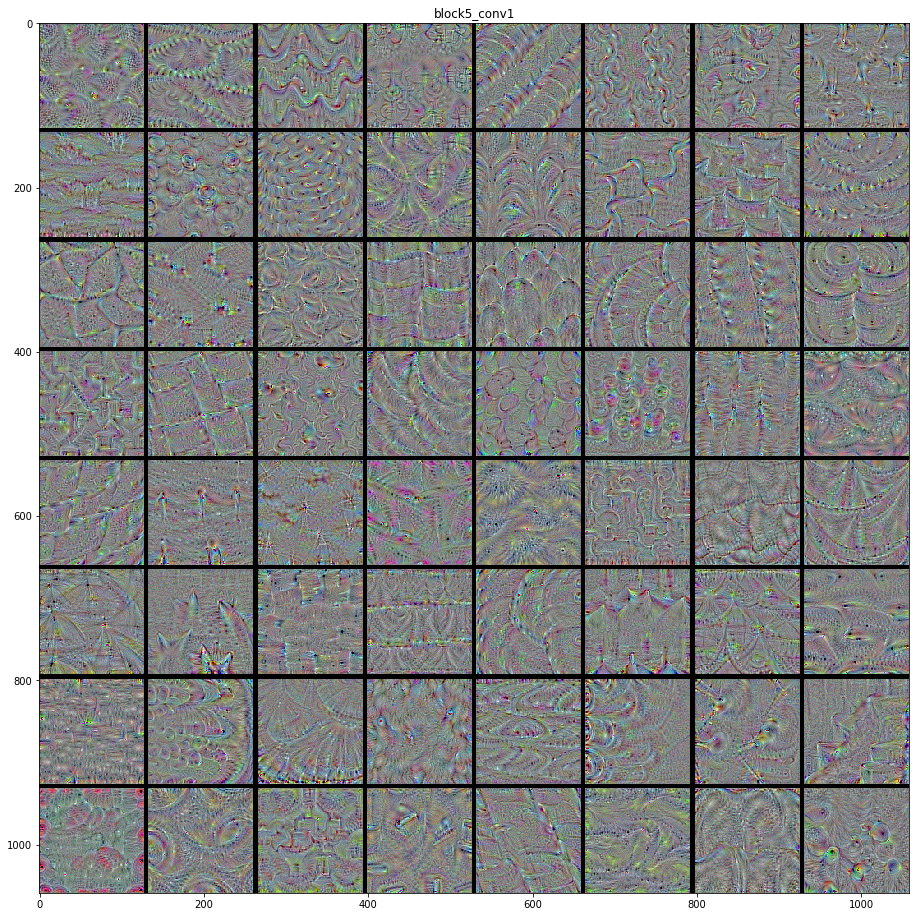

In [21]:
plt.figure(figsize=(16, 16))
plt.imshow(stitched_filters)
plt.title(layer_name)

In [22]:
layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7f6b03c7f190>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7f6b03c7f1d0>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x7f6b03c7f390>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x7f6b03c23f90>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x7f6b03c3ac10>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x7f6b03c4fc10>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x7f6b039d3bd0>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x7f6b039e6a90>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x7f6b039f9890>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x7f6b0398ea10>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x7f6b03948b50>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x7f6b03948d90>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x7f6b03970ad0>,
 'block4_pool': <keras.layers.pooling.MaxPooling2D at 0x7f6b03903dd

CPU times: user 55.4 s, sys: 381 ms, total: 55.8 s
Wall time: 54 s


Text(0.5,1,u'block1_conv1')

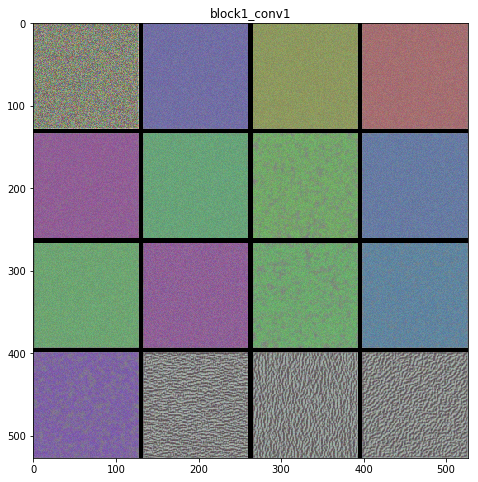

In [24]:
%time stitched_filters = update_input_img(layer_name='block1_conv1', n_base=64, n_choose=16)

plt.figure(figsize=(8, 8))
plt.imshow(stitched_filters)
plt.title('block1_conv1')

CPU times: user 1min 3s, sys: 766 ms, total: 1min 3s
Wall time: 1min 2s


Text(0.5,1,u'block2_conv1')

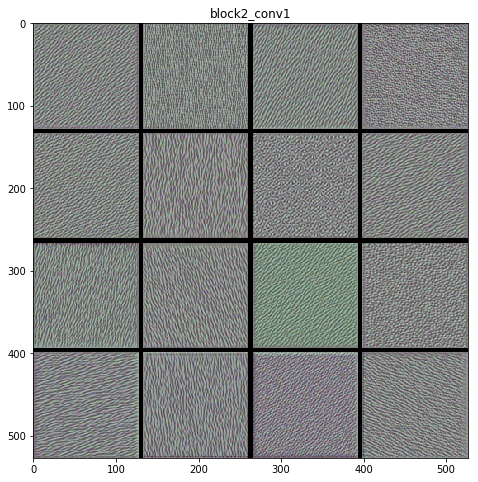

In [26]:
layer_name = 'block2_conv1'
%time stitched_filters = update_input_img(layer_name=layer_name, n_base=64, n_choose=16)

plt.figure(figsize=(8, 8))
plt.imshow(stitched_filters)
plt.title(layer_name)

CPU times: user 1min 9s, sys: 1.11 s, total: 1min 10s
Wall time: 1min 9s


Text(0.5,1,u'block3_conv1')

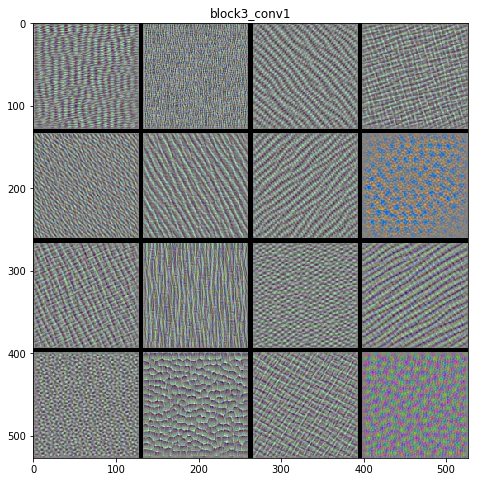

In [27]:
layer_name = 'block3_conv1'
%time stitched_filters = update_input_img(layer_name=layer_name, n_base=64, n_choose=16)

plt.figure(figsize=(8, 8))
plt.imshow(stitched_filters)
plt.title(layer_name)

CPU times: user 1min 35s, sys: 1.42 s, total: 1min 37s
Wall time: 1min 36s


Text(0.5,1,u'block4_conv3')

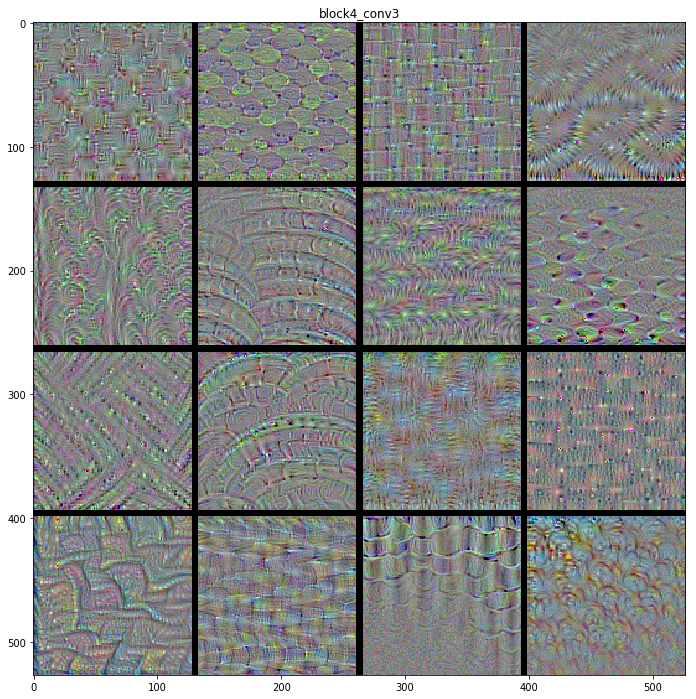

In [31]:
layer_name = 'block4_conv3'
%time stitched_filters = update_input_img(layer_name=layer_name, n_base=64, n_choose=16)

plt.figure(figsize=(12, 12))
plt.imshow(stitched_filters)
plt.title(layer_name)

### A remarkable observation: 
a lot of these filters are identical, but rotated by some non-random factor (typically 90 degrees).   
This means that we could potentially compress the number of filters used in a convnet by a large factor by finding a way to make the convolution filters rotation-invariant.   
I can see a few ways this could be achieved --it's an interesting research direction.